In [1]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
import pandas as pd
import os
import random
import time

from torch import Tensor

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms.functional as TF
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision
from torchvision import transforms
from torch.optim import Adam, SGD

# !pip install torchmetrics
# import torchmetrics

!pip install torchinfo
from torchinfo import summary

In [2]:
#For ensuaring the reproducible results
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [3]:
image_size = 512
batch_size = 16

In [4]:
df_train = pd.read_csv('../input/fgvc-aircraft/train.csv')
df_val = pd.read_csv('../input/fgvc-aircraft/val.csv')
df_test = pd.read_csv('../input/fgvc-aircraft/test.csv')
df_train.head()

filename  Classes  Labels
0  1025794.jpg  707-320       0
1  1340192.jpg  707-320       0
2  0056978.jpg  707-320       0
3  0698580.jpg  707-320       0
4  0450014.jpg  707-320       0

In [5]:
tpath = "../input/fgvc-aircraft/fgvc-aircraft-2013b/fgvc-aircraft-2013b/data/images"
df_train = df_train.assign(Paths = tpath + "/" + df_train["filename"])
df_val = df_val.assign(Paths = tpath + "/" + df_val["filename"])
df_test = df_test.assign(Paths = tpath + "/" + df_test["filename"])

def get_data(df):
    data = []
    for idx in range(len(df)):
        data.append((str(df.at[idx,"Paths"]),df.at[idx,"Labels"]))
    return data

data_train = get_data(df_train)
data_val = get_data(df_val)
data_test = get_data(df_test)
print(data_train[10])
print(data_train[100])
print(len(data_train))
print(len(data_val))
print(len(data_test))


('../input/fgvc-aircraft/fgvc-aircraft-2013b/fgvc-aircraft-2013b/data/images/0951982.jpg', 0)
('../input/fgvc-aircraft/fgvc-aircraft-2013b/fgvc-aircraft-2013b/data/images/1899111.jpg', 3)
3334
3333
3333


In [6]:
# #Get the infos about the size of the data
# for x, y in data_train:
#     example_image = cv2.cvtColor(cv2.imread(x), cv2.COLOR_BGR2RGB)
#     print(example_image.shape)

##The quality of most of the pictures are quite good (approximately around (512, 1024,3)). So we're going to convert the pic to 512x512x3

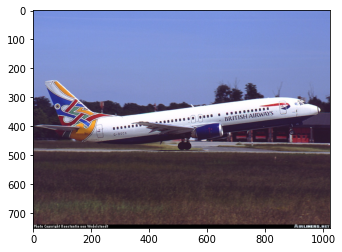

In [7]:
#We notice that there'are 20-pixels high authorship informations (according to the dataset's informations)
example_image = cv2.cvtColor(cv2.imread(data_train[150][0]), cv2.COLOR_BGR2RGB)
plt.imshow(example_image)

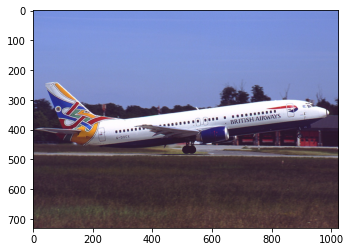

In [8]:
#Crop the banner (authorship information) (20 pixels high at the bottom)
example_image = cv2.cvtColor(cv2.imread(data_train[150][0]), cv2.COLOR_BGR2RGB)
example_image
plt.imshow(example_image[0:-20, :])

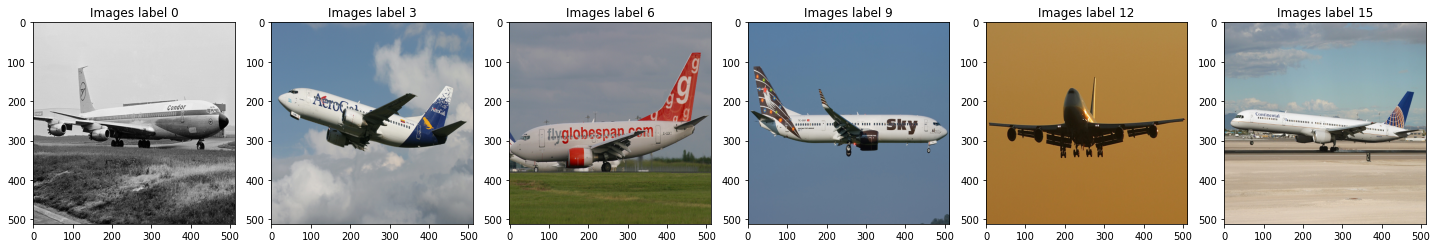

In [9]:
#Vision about the data
num_images = 6
figures,axis = plt.subplots(1,num_images,figsize=(20,20))

for idx in range(num_images):
  example_image = cv2.cvtColor(cv2.imread(data_train[100*idx][0]), cv2.COLOR_BGR2RGB)

    #Remove the banner (authorship information)
  example_image = example_image[0:-20,:]

  example_image = cv2.resize(example_image, (image_size,image_size),interpolation=cv2.INTER_CUBIC)

  axis[idx].set_title("Images label " + str(data_train[100*idx][1]))
  axis[idx].imshow(example_image)


#OpenCV uses BGR while mathplotlib uses RGB
plt.tight_layout()
plt.show()

In [10]:
class LoadDataset(Dataset):
    def __init__(self, data, transform, image_size):
        self.data = data
        self.len = len(self.data)
        self.transform = transform
        self.size = image_size

        
    def __len__(self):
        return self.len
    
    def __getitem__(self,idx):
        image_path, label = self.data[idx]

        img = np.array(cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB))
        
        #Crop the banner (20-pixels high)
        img = img[0:-20,:]
        
        resized_img = cv2.resize(img, (self.size,self.size),interpolation =cv2.INTER_CUBIC).astype("float32")/255
        
        #From BGR (default in OpenCV), return the RGB image
        image_tensor = torch.from_numpy(np.transpose(resized_img,(2,0,1)))
        
        #Return the transformed images and the label
        
        return self.transform(image_tensor), label

In [11]:
#Transform
transformed = transforms.Compose([
                    transforms.RandomHorizontalFlip(p=0.5),
                    transforms.Normalize([0.5,0.5,0.5],[0.5,0.5,0.5])    #From ImageNet  
                    ])

#Device

device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [12]:
train_set = LoadDataset(data=data_train, transform=transformed, image_size=image_size)
val_set = LoadDataset(data=data_val, transform=transformed, image_size=image_size)
test_set = LoadDataset(data=data_test, transform=transforms.Normalize([0.5,0.5,0.5],[0.5,0.5,0.5]), image_size=image_size)

In [13]:
# for x,y in train_set:
#     print(x,y)
#     break
# for x,y in val_set:
#     print(x,y)
#     break

In [14]:
train_loader = torch.utils.data.DataLoader(
    train_set, batch_size = batch_size, shuffle = True, num_workers =2
)
val_loader = torch.utils.data.DataLoader(
    val_set, batch_size = batch_size, shuffle = True, num_workers =2
)
test_loader = torch.utils.data.DataLoader(
    test_set, batch_size = batch_size, shuffle = True
)

In [15]:
import torch
from torch import nn, Tensor
from torch.nn import functional as F


class DropPath(nn.Module):
    
    def __init__(self, p: float = None):
        super().__init__()
        self.p = p

    def forward(self, x: Tensor) -> Tensor:
        if self.p == 0. or not self.training:
            return x
        kp = 1 - self.p
        shape = (x.shape[0],) + (1,) * (x.ndim - 1)
        random_tensor = kp + torch.rand(shape, dtype=x.dtype, device=x.device)
        random_tensor.floor_()  # binarize
        return x.div(kp) * random_tensor


class Attention(nn.Module):
    def __init__(self, dim, head, sr_ratio):
        super().__init__()
        self.head = head
        self.sr_ratio = sr_ratio 
        self.scale = (dim // head) ** -0.5
        self.q = nn.Linear(dim, dim)
        self.kv = nn.Linear(dim, dim*2)
        self.proj = nn.Linear(dim, dim)

        if sr_ratio > 1:
            self.sr = nn.Conv2d(dim, dim, sr_ratio, sr_ratio)
            self.norm = nn.LayerNorm(dim)

    def forward(self, x: Tensor, H, W) -> Tensor:
        B, N, C = x.shape
        q = self.q(x).reshape(B, N, self.head, C // self.head).permute(0, 2, 1, 3)

        if self.sr_ratio > 1:
            x = x.permute(0, 2, 1).reshape(B, C, H, W)
            x = self.sr(x).reshape(B, C, -1).permute(0, 2, 1)
            x = self.norm(x)
            
        k, v = self.kv(x).reshape(B, -1, 2, self.head, C // self.head).permute(2, 0, 3, 1, 4)

        attn = (q @ k.transpose(-2, -1)) * self.scale
        attn = attn.softmax(dim=-1)

        x = (attn @ v).transpose(1, 2).reshape(B, N, C)
        x = self.proj(x)
        return x


class DWConv(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dwconv = nn.Conv2d(dim, dim, 3, 1, 1, groups=dim)

    def forward(self, x: Tensor, H, W) -> Tensor:
        B, _, C = x.shape
        x = x.transpose(1, 2).view(B, C, H, W)
        x = self.dwconv(x)
        return x.flatten(2).transpose(1, 2)


class MLP(nn.Module):
    def __init__(self, c1, c2):
        super().__init__()
        self.fc1 = nn.Linear(c1, c2)
        self.dwconv = DWConv(c2)
        self.fc2 = nn.Linear(c2, c1)
        
    def forward(self, x: Tensor, H, W) -> Tensor:
        return self.fc2(F.gelu(self.dwconv(self.fc1(x), H, W)))


class PatchEmbed(nn.Module):
    def __init__(self, c1=3, c2=32, patch_size=7, stride=4):
        super().__init__()
        self.proj = nn.Conv2d(c1, c2, patch_size, stride, patch_size//2)    # padding=(ps[0]//2, ps[1]//2)
        self.norm = nn.LayerNorm(c2)

    def forward(self, x: Tensor) -> Tensor:
        x = self.proj(x)
        _, _, H, W = x.shape
        x = x.flatten(2).transpose(1, 2)
        x = self.norm(x)
        return x, H, W


class Block(nn.Module):
    def __init__(self, dim, head, sr_ratio=1, dpr=0.):
        super().__init__()
        self.norm1 = nn.LayerNorm(dim)
        self.attn = Attention(dim, head, sr_ratio)
        self.drop_path = DropPath(dpr) if dpr > 0. else nn.Identity()
        self.norm2 = nn.LayerNorm(dim)
        self.mlp = MLP(dim, int(dim*4))

    def forward(self, x: Tensor, H, W) -> Tensor:
        x = x + self.drop_path(self.attn(self.norm1(x), H, W))
        x = x + self.drop_path(self.mlp(self.norm2(x), H, W))
        return x


mit_settings = {
    'B0': [[32, 64, 160, 256], [2, 2, 2, 2]],        # [embed_dims, depths]
    'B1': [[64, 128, 320, 512], [2, 2, 2, 2]],
    'B2': [[64, 128, 320, 512], [3, 4, 6, 3]],
    'B3': [[64, 128, 320, 512], [3, 4, 18, 3]],
    'B4': [[64, 128, 320, 512], [3, 8, 27, 3]],
    'B5': [[64, 128, 320, 512], [3, 6, 40, 3]]
}


class MiT(nn.Module):
    def __init__(self, model_name: str = 'B0'):
        super().__init__()
        assert model_name in mit_settings.keys(), f"MiT model name should be in {list(mit_settings.keys())}"
        embed_dims, depths = mit_settings[model_name]
        drop_path_rate = 0.1
        self.channels = embed_dims

        # patch_embed
        self.patch_embed1 = PatchEmbed(3, embed_dims[0], 7, 4)
        self.patch_embed2 = PatchEmbed(embed_dims[0], embed_dims[1], 3, 2)
        self.patch_embed3 = PatchEmbed(embed_dims[1], embed_dims[2], 3, 2)
        self.patch_embed4 = PatchEmbed(embed_dims[2], embed_dims[3], 3, 2)

        dpr = [x.item() for x in torch.linspace(0, drop_path_rate, sum(depths))]
        
        cur = 0
        self.block1 = nn.ModuleList([Block(embed_dims[0], 1, 8, dpr[cur+i]) for i in range(depths[0])])
        self.norm1 = nn.LayerNorm(embed_dims[0])

        cur += depths[0]
        self.block2 = nn.ModuleList([Block(embed_dims[1], 2, 4, dpr[cur+i]) for i in range(depths[1])])
        self.norm2 = nn.LayerNorm(embed_dims[1])

        cur += depths[1]
        self.block3 = nn.ModuleList([Block(embed_dims[2], 5, 2, dpr[cur+i]) for i in range(depths[2])])
        self.norm3 = nn.LayerNorm(embed_dims[2])

        cur += depths[2]
        self.block4 = nn.ModuleList([Block(embed_dims[3], 8, 1, dpr[cur+i]) for i in range(depths[3])])
        self.norm4 = nn.LayerNorm(embed_dims[3])


    def forward(self, x: Tensor) -> Tensor:
        B = x.shape[0]
        # stage 1
        x, H, W = self.patch_embed1(x)
        for blk in self.block1:
            x = blk(x, H, W)
        x1 = self.norm1(x).reshape(B, H, W, -1).permute(0, 3, 1, 2)

        # stage 2
        x, H, W = self.patch_embed2(x1)
        for blk in self.block2:
            x = blk(x, H, W)
        x2 = self.norm2(x).reshape(B, H, W, -1).permute(0, 3, 1, 2)

        # stage 3
        x, H, W = self.patch_embed3(x2)
        for blk in self.block3:
            x = blk(x, H, W)
        x3 = self.norm3(x).reshape(B, H, W, -1).permute(0, 3, 1, 2)

        # stage 4
        x, H, W = self.patch_embed4(x3)
        for blk in self.block4:
            x = blk(x, H, W)
        x4 = self.norm4(x).reshape(B, H, W, -1).permute(0, 3, 1, 2)

        return x4


In [16]:
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# #This will be the encoder we'll use
# encoder =MiT('B0')

# summary(encoder, input_size=(16, 3, image_size, image_size))

In [17]:
# class CNN_middle(nn.Module):
#     def __init__(self):
#         super().__init__()
#         self.mish=nn.Mish()        
#         self.pool=nn.MaxPool2d(kernel_size=2)
        
#         self.conv1=nn.Conv2d(in_channels=64,out_channels=128,kernel_size=3,stride=1,padding="same")
#         self.bn1 = nn.BatchNorm2d(128)
#         self.conv2=nn.Conv2d(in_channels=128, out_channels=256,kernel_size=3,stride=1, padding = "same")
#         self.bn2 = nn.BatchNorm2d(256)
#         self.conv3=nn.Conv2d(in_channels=256,out_channels=512,kernel_size=3,stride=1,padding= "same")
#         self.bn3 = nn.BatchNorm2d(512)
        
#     def forward(self, x:Tensor) -> Tensor:
#         output = self.pool(self.mish(self.bn1(self.conv1(x))))
#         output = self.pool(self.mish(self.bn2(self.conv2(output))))
#         output = self.pool(self.mish(self.bn3(self.conv3(output))))
        
#         return output
        
        
        
class SegFormer_Based(nn.Module):
    def __init__(self,num_classes):
        super().__init__()
        self.encoder = MiT("B0")
        
        
        self.flatten = nn.Flatten()
        self.mish = nn.Mish()
        self.dense1 = nn.Linear(256*16*16, 256)
        self.dense2 = nn.Linear(256,num_classes)
        
        
        
        
        
    def forward(self, x: Tensor) -> Tensor:
        encoder = self.encoder(x)
        
        output = self.flatten(encoder)
        output = self.dense2(self.mish(self.dense1(output)))
        
        return output
        
    
    

In [18]:
model =SegFormer_Based(100).to(device)

summary(model, input_size=(16, 3, image_size, image_size))

Layer (type:depth-idx)                        Output Shape              Param #
SegFormer_Based                               [16, 100]                 --
├─MiT: 1-1                                    [16, 256, 16, 16]         1,281,184
│    └─PatchEmbed: 2-1                        [16, 16384, 32]           --
│    │    └─Conv2d: 3-1                       [16, 32, 128, 128]        4,736
│    │    └─LayerNorm: 3-2                    [16, 16384, 32]           64
│    └─PatchEmbed: 2-7                        [16, 4096, 64]            (recursive)
│    │    └─Conv2d: 3-11                      [16, 64, 64, 64]          (recursive)
│    │    └─LayerNorm: 3-12                   [16, 4096, 64]            (recursive)
│    └─PatchEmbed: 2-9                        [16, 1024, 160]           (recursive)
│    │    └─Conv2d: 3-15                      [16, 160, 32, 32]         (recursive)
│    │    └─LayerNorm: 3-16                   [16, 1024, 160]           (recursive)
│    └─PatchEmbed: 2-11        

In [19]:
def train_epoch(net, dataloader, lr = 0.01, optimizer=None, loss_fn = nn.NLLLoss()):
  optimizer = optimizer or torch.optim.Adam(net.parameters(), lr = lr)
  net.train()
  total_loss, acc, count = 0,0,0
  for features, labels in dataloader:
    optimizer.zero_grad()
    lbls = labels.to(device)
    out = net(features.to(device))
    loss = loss_fn(out, lbls) #cross_entropy(out, labels)
    loss.backward()
    optimizer.step()
    total_loss +=loss
    _, predicted = torch.max(out,1)
    acc +=(predicted == lbls).sum()
    count += len(labels)
  
  return total_loss.item()/count, acc.item()/count

def validate(net, dataloader, loss_fn = nn.NLLLoss()):
  net.eval()
  count, acc, loss = 0,0,0
  with torch.no_grad():
    for features, labels in dataloader:
      lbls = labels.to(device)
      out = net(features.to(device))
      loss += loss_fn(out,lbls)
      pred = torch.max(out,1)[1]
      acc += (pred==lbls).sum()
      count += len(labels)

  return loss.item()/count, acc.item()/count

def train(net, train_loader, val_loader, optimizer = None, lr = 0.001, epochs = 10, loss_fn = nn.NLLLoss()):
  optimizer = optimizer or torch.optim.Adam(net.parameters(), lr = lr)
  best_accuracy=0.0
  res = {"train_loss":[], "train_acc":[], "val_loss":[], "val_acc":[]}
  for ep in range(epochs):
    since = time.time()
    
    
    tl,ta = train_epoch(net,train_loader, optimizer = optimizer, lr=lr, loss_fn = loss_fn)
    vl, va = validate(net, val_loader, loss_fn = loss_fn)
    print(f"Epoch {ep}, Train acc = {ta:.3f}, Val acc = {va:.3f}, Train loss = {tl:.3f}, Val loss = {vl:.3f}")
    res["train_loss"].append(tl)
    res["train_acc"].append(ta)
    res["val_loss"].append(vl)
    res["val_acc"].append(va)
    if va>best_accuracy:
        torch.save(net,"/kaggle/working/BestModel.pt")
        best_accuracy=va
        
    time_elapsed = time.time() - since
    print('{:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
  return res
def plot_results(hist):
  plt.figure(figsize = (15,15))
  plt.subplot(1,2,1)
  plt.plot(hist["train_acc"], label = "Training acc")
  plt.plot(hist["val_acc"], label = "Validation acc")
  plt.legend()
  plt.subplot(1,2,2)
  plt.plot(hist["train_loss"], label = "Training loss")
  plt.plot(hist["val_loss"], label = "Validation loss")
  plt.legend()

Epoch 0, Train acc = 0.016, Val acc = 0.013, Train loss = 0.291, Val loss = 0.287
2m 59s
Epoch 1, Train acc = 0.023, Val acc = 0.020, Train loss = 0.285, Val loss = 0.289
2m 52s
Epoch 2, Train acc = 0.033, Val acc = 0.024, Train loss = 0.281, Val loss = 0.286
2m 54s
Epoch 3, Train acc = 0.043, Val acc = 0.027, Train loss = 0.277, Val loss = 0.286
2m 52s
Epoch 4, Train acc = 0.062, Val acc = 0.038, Train loss = 0.270, Val loss = 0.282
2m 52s
Epoch 5, Train acc = 0.082, Val acc = 0.042, Train loss = 0.263, Val loss = 0.291
2m 52s
Epoch 6, Train acc = 0.106, Val acc = 0.048, Train loss = 0.256, Val loss = 0.281
2m 52s
Epoch 7, Train acc = 0.137, Val acc = 0.049, Train loss = 0.245, Val loss = 0.289
2m 53s
Epoch 8, Train acc = 0.176, Val acc = 0.049, Train loss = 0.233, Val loss = 0.281
2m 53s
Epoch 9, Train acc = 0.212, Val acc = 0.033, Train loss = 0.219, Val loss = 0.323
2m 50s
Epoch 10, Train acc = 0.264, Val acc = 0.070, Train loss = 0.202, Val loss = 0.283
2m 53s
Epoch 11, Train acc 

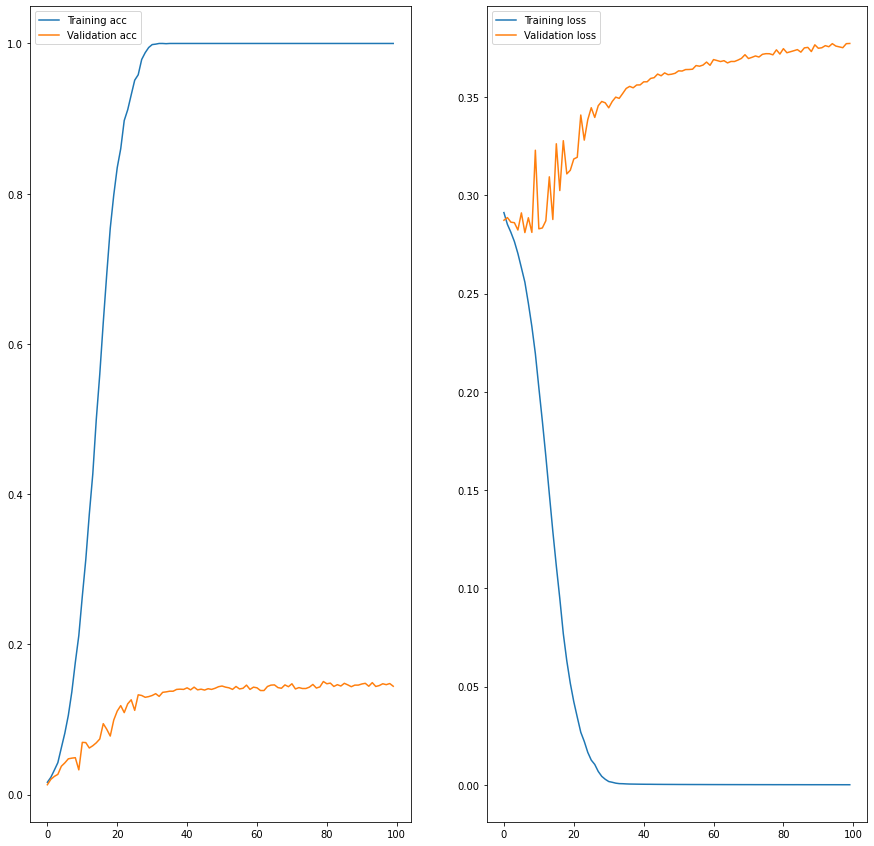

In [20]:
hist = train(model,train_loader,val_loader,optimizer = SGD(model.parameters(),lr=0.01), epochs=100, loss_fn = nn.CrossEntropyLoss())
plot_results(hist)

In [21]:
loss_test, acc_test =  validate(model, test_loader, loss_fn = nn.CrossEntropyLoss())

In [22]:
print(f"Loss on test set is {loss_test}, accuracy on test set {acc_test}")

Loss on test set is 0.3796674589333933, accuracy on test set 0.1416141614161416
